# Workflow to calculate the quantum efficiency of a polycrystalline material

In [1]:
import subprocess
import nglview as nv

from ase.calculators.castep import Castep
from ase.atoms import Atoms
from ase.io import read, write
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep
from ase.io.castep import read_castep_cell

from pymatgen.ext.matproj import MPRester
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import SlabGenerator, generate_all_slabs, Slab, miller_index_from_sites, get_d
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.wulff import WulffShape
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.symmetry.kpath import KPathLatimerMunro
from pymatgen.vis.structure_chemview import quick_view

from wulffpack import SingleCrystal

from functions import *

I recommend using pymatgen to generate the bulk/slab and then convert it to an ASE atom object. The advantages of this approach are:
- pymatgen has a better bulk/slab generation algorithm 
- castep can link a calculator to the Atom object


#### Download and save .cif file for necessary materials

In [ ]:
import json
api_key = ''
with MPRester(api_key) as m:
    results = m.get_dos_by_material_id("mp-30")
#print(type(results))
#res_json = results.as_dict()
with open('./structures/jsons/DOS/Cu_bulk_dos_ref.json', 'w') as f:
    json.dump(results.as_dict(), f)

#### Generate the bulk structure and bulk input

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
seed = 'Cu_bulk_murn_ext'
murn, minimal_struct, energies,volumes = read_murnaghan_outputs(seed = seed, structure = bulk,path = f'./structures/EOS_tests/PBEsol/{seed}/')
fig= murn.plot()
plt.style.use('seaborn-darkgrid')
#view(AseAtomsAdaptor().get_atoms(bulk))
bulk_seed = 'Cu_bulk_'
GeneralOptions = {
    'directory': f"./structures/",
    'seed' : bulk_seed,
    'tasks' : [],
}
CastepOptions = {
    'directory': f"./structures/{bulk_seed}",
    'label': bulk_seed,
    # Param File Instructions
    'task': 'Spectral', #Choose: SinglePoint, BandStructure, Spectral
    'spectral_task' : 'ALL', #Choose if task is Spectral: DOS, BandStructure, Optics, CoreLoss, All 
    'xc_functional': 'PBE',
    'energy_cutoff': 600,
    'elec_energy_tol': 1e-8,
    'opt_strategy': 'Speed',
    'fix_occup' : False,
    'mixing_scheme' : 'Broydon', #Choose from Broydon or Pulay
    'smearing_width' : 300,
    'spin_polarized': False,
    'max_scf_cycles': 1000,
    'write_potential': False,
    'write_density': False,
    'extra_bands': True,
    #Cell File Instructions
    'kpoints': (32,32,1),
    'snap_to_symmetry': False,
    'fix_all_cell': False,
    'continuation': False,
    'bandstruct_path': 'GXWKGLUWLK',
    'bandstruct_kpt_dist': 0.0184,
    'spectral_kpt_grid': (10,10,10),
    'calculate_pdos': True 
}
PBSOptions = {
    'seed_name': bulk_seed,
    'tasks_seeds': [['singlepoint', bulk_seed], ['Optados', bulk_seed]], #Choose one or multiple (carefully!): SinglePoint, BandStructure, Spectral, OptaDOS
    'queue': 'debug',
    'castep_version': 'castep_19' #choose from castep_19, castep_18, castep_18_mod
}
OptaDOSOptions = {
    'seed_name': bulk_seed,
    'optados_task': 'pdos', # Choose: dos(default), compare_dos, compare_jdos, jdos, pdos, optics, core, all
    'broadening': 'adaptive', #Choose: adaptive(default), fixed, linear
    'iprint': '1', #Choose: 1 - bare minimum, 2 - with progress reports, 3 - fulld debug output
    'efermi': 'optados', #Choose: optados - recalculate, file - read from CASTEP file, insulator - count filled bands, float - supplied by user
    'dos_spacing': '0.001', #DOS spacing in unit (default: eV): default - 0.1
    'pdos': 'angular', #Choose: angular, species_ang, species, sites or more detailed descriptions such as: 
    #PDOS : sum:Si1-2(s) - sum of s-chnnls on 2 Si atms (1 proj), 
    #PDOS : Si1;Si2(s) - DOS on Si atom 1 and DOS on s-channel of Si atom 2 (2 proj) 
    'photo_options': {
        'work_function' : 4.556,
        's_area' : 6.339744873,
        'slab_volume' : 190.942338,
        'elec_field' : 0,
        'imfp_const' : 19.0,
        'JDOS_SPACING' : 0.1,
        'JDOS_MAX_ENERGY' : 25,
        'BROADENING' : 'linear',
        'OPTICS_GEOM' : 'unpolar',
        'optics_qdir' : [1, 1.000, 1.0000],
        'photon_energy' : 21.2,
        'linear_smearing' : 0.026,
        'fixed_smearing' :  0.026,
        'optics_intraband' : True,
        'photo_model' : '1step',
        'momentum' : 'crystal',
        'hybrid_linear' : True,
        'temp' : 300,
        'theta_lower' : 59,
        'theta_upper' : 61,
        'photo_output' : 'be'
        }
}
options = {'general':GeneralOptions,'castep':CastepOptions,'pbs':PBSOptions,'optados':OptaDOSOptions}
generate_input_files(calc_struct=AseAtomsAdaptor().get_atoms(bulk),**options)
generate_castep_input(calc_struct=AseAtomsAdaptor().get_atoms(bulk), **options)
generate_qsub_file(**options)
generate_optados_input(**options)

#### Generate the surface structure

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
print(bulk)
#view(AseAtomsAdaptor.get_atoms(bulk))
analyser = SpacegroupAnalyzer(bulk)
bulk_conv = analyser.get_refined_structure()
#view(AseAtomsAdaptor().get_atoms(bulk_conv))
bulk_ase = AseAtomsAdaptor().get_atoms(bulk_conv)

#print(bulk)
#surface = ase.build.surface(lattice = bulk_ase, indices = (1,0,0), layers = 8, vacuum=15, tol=1e-10, periodic=True)
#view(surface)b

In [4]:
#view(read('./structures/Cu_surf_111/Cu_surf_111.xyz'))
view(AseAtomsAdaptor.get_atoms(read_cell2pmg('./structures/geometry_opt/Cu_surf_111/Cu_surf_111.cell')))

<Popen: returncode: None args: ['c:\\Users\\felixmildner\\miniconda3\\envs\\...>

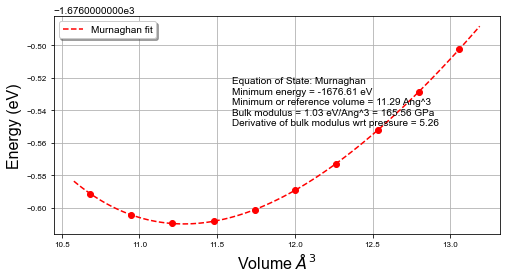

In [2]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
seed = 'Cu_bulk_murn_ext'
murn, minimal_struct, energies,volumes = read_murnaghan_outputs(seed = seed, structure = bulk,path = f'./structures/EOS_tests/PBEsol/{seed}/')
fig= murn.plot()
plt.style.use('seaborn-darkgrid')

conventional = SpacegroupAnalyzer(minimal_struct).get_conventional_standard_structure()
#view(AseAtomsAdaptor.get_atoms(conventional))

In [21]:
data_111 = SlabGenerator(conventional,[1,1,1],31,20,center_slab=True).get_slabs()[0].get_orthogonal_c_slab()
data_111_2 = SlabGenerator(conventional,[1,1,1],31,20,center_slab=True,primitive=False).get_slabs()[0].get_orthogonal_c_slab()
data_110 = SlabGenerator(conventional,[1,1,0],18,20,center_slab=True).get_slabs()[0]
data_100 = SlabGenerator(conventional,[1,0,0],26,20,center_slab=True).get_slabs()[0]
view(AseAtomsAdaptor.get_atoms(data_111))
view(AseAtomsAdaptor.get_atoms(data_111_2))

<Popen: returncode: None args: ['c:\\Users\\felixmildner\\miniconda3\\envs\\...>

In [18]:
from pymatgen.transformations.standard_transformations import *
rotation = RotationTransformation([0,0,1], 120)
rotated = rotation.apply_transformation(data_111)
print(rotated)
rotated_2 = AseAtomsAdaptor.get_atoms(data_111)
rotated_2.rotate(120,'z', rotate_cell=True)
view(rotated_2)
#view(AseAtomsAdaptor.get_atoms(rotated))

Slab Summary (Cu16)
Reduced Formula: Cu
Miller index: (1, 1, 1)
Shift: 0.5000, Scale Factor: [[-1  1  0]
 [-1  0  1]
 [ 1  0  0]]
abc   :   2.517723   2.517723  53.448517
angles:  90.000000  90.000000  60.000000
Sites (16)
1 Cu     0.666667     0.666667     0.788462
2 Cu     1.000000     1.000000     0.750000
3 Cu     0.333333     0.333333     0.711538
4 Cu     0.666667     0.666667     0.673077
5 Cu     1.000000     1.000000     0.634615
6 Cu     0.333333     0.333333     0.596154
7 Cu     0.666667     0.666667     0.557692
8 Cu     1.000000     1.000000     0.519231
9 Cu     0.333333     0.333333     0.480769
10 Cu     0.666667     0.666667     0.442308
11 Cu     1.000000     1.000000     0.403846
12 Cu     0.333333     0.333333     0.365385
13 Cu     0.666667     0.666667     0.326923
14 Cu     1.000000     1.000000     0.288462
15 Cu     0.333333     0.333333     0.250000
16 Cu     0.666667     0.666667     0.211538


<Popen: returncode: None args: ['c:\\Users\\felixmildner\\miniconda3\\envs\\...>

In [ ]:
view(read('./structures/Cu_surf_111/Cu_surf_111.xyz'))

In [ ]:
#surfaces = generate_all_slabs(structure=bulk_conv,max_index=1,min_slab_size=16, min_vacuum_size=6, center_slab=True, in_unit_planes=True)
surfaces = {}

surfaces['111'] = SlabGenerator(bulk_conv, [1,1,1],  min_slab_size=32, min_vacuum_size=22, center_slab = True).get_slabs()[0]
surfaces['110'] = SlabGenerator(bulk_conv, [1,1,0],  min_slab_size=18, min_vacuum_size=22, center_slab = True).get_slabs()[0]
surfaces['100'] = SlabGenerator(bulk_conv, [1,0,0],  min_slab_size=26, min_vacuum_size=22, center_slab = True).get_slabs()[0]
# print(surfaces)
for index,item in enumerate(surfaces.keys()):
    #print(surfaces)
    #print(len(surfaces[item]))
    #print(miller_index_from_sites(surfaces[item].lattice, surfaces[item].frac_coords, False))
    #print(surfaces[item])
    #write(f'./structures/xyz/Cu_surf_{hkl[index]}.xyz',AseAtomsAdaptor.get_atoms(surfaces[item]))
    view(AseAtomsAdaptor.get_atoms(surfaces[item]))

In [ ]:
surface_111_ortho = SlabGenerator(bulk, [1,1,0], min_slab_size=16, min_vacuum_size=6, center_slab = True, in_unit_planes=True).get_slabs()[0].get_orthogonal_c_slab()
surface_111 = SlabGenerator(bulk, [1,1,0], min_slab_size=16, min_vacuum_size=6, center_slab = True, in_unit_planes=True).get_slabs()[0]
surface_111_ase = ase.build.surface(lattice = bulk_ase, indices = [1,1,0], layers = 16, vacuum=15, tol=1e-10, periodic=True)
#view(AseAtomsAdaptor.get_atoms(surface_111_ortho))
print(surface_111_ortho)
#print(f'Pymatgen d = {get_d(surface_111)}')
#a = np.rad2deg(np.arcsin(get_d(surface_111_ortho)/get_d(surface_111)))
#print(a)
#print(f'Pymatgen adjusted d = {get_d(surface_111)*np.sin(np.deg2rad(60))}')
#print(f'Pymatgen ortho d = {get_d(surface_111_ortho)}')
#print(f'ASE d = {get_d(AseAtomsAdaptor.get_structure(surface_111_ase))}')

In [ ]:
surfaces = generate_all_slabs(structure=bulk_conv,max_index=1,min_slab_size=16, min_vacuum_size=6, center_slab=True, in_unit_planes=True)
indices = [[1,1,0]]#,[1,0,0]]#,[1,1,0]]
hkl = ['110','100','110']
surfaces = {}
for index,item in enumerate(indices):
    surfaces[hkl[index]] = ase.build.surface(lattice = bulk_ase, indices = item, layers = 16, vacuum=15, tol=1e-10, periodic=True)
for item in surfaces.keys():
    view(surfaces[item])

In [20]:
surfaces = {}
data_111 = read('./structures/Cu_surf_111/Cu111_rotated.xyz')
# data_111 = SlabGenerator(conventional,[1,1,1],31,20,center_slab=True).get_slabs()[0].get_orthogonal_c_slab()
# data_110 = read('./structures/Cu_surf_110/Cu_surf_110.xyz')
# data_100 = read('./structures/Cu_surf_100/Cu_surf_100.xyz')
surfaces['111'] = {'structure' : data_111}
#surfaces['110'] = {'structure' : data_110}
#surfaces['100'] = {'structure' : data_100}
# surfaces['111']['bandpath'] = 'MGKM' #111 MGKM hex primitive
# surfaces['110']['bandpath'] = "GYXSGX" #110  GYXSGX primitive orthorhombic"
# surfaces['100']['bandpath'] = 'XGMX' #100 XGMX tetragonal primitive

GeneralOptions = {
    'directory': f"./structures/",
    'seed' : seed,
    'tasks' : [],
}
CastepOptions  = {
    'directory': f"./structures/",
    'seed_name': seed,
    # Param File Instructions
    'task': 'GeometryOptimization', #Choose: SinglePoint, BandStructure, Spectral, GeometryOptimization
    'spectral_task' : 'All', #Choose if task is Spectral: DOS, BandStructure, Optics, CoreLoss, All 
    'calculate_pdos': True,
    'xc_functional': 'PBEsol',
    'energy_cutoff': 600,
    'elec_energy_tol': 1e-8,
    'opt_strategy': 'Speed',
    'fix_occup' : False,
    'mixing_scheme' : 'Pulay', #Choose from Broydon or Pulay
    'smearing_width' : 300, # Temperature in Kelvin
    'spin_polarized': False,
    'max_scf_cycles': 1000,
    'write_potential': True,
    'write_density': True,
    'extra_bands': True,
    #Cell File Instructions
    'kpoints': (32,32,1),
    'snap_to_symmetry': True,
    'generate_symmetry': True,
    'fix_all_cell': True,
    'continuation': False,
    'bandstruct_path': 'GXWKGLUWLK',
    'bandstruct_kpt_dist': 0.0184,
    'spectral_kpt_grid': (32,32,1)    
}
PBSOptions = {
    'seed_name': '',
    #choose from castep_19, castep_18, castep_18_mod, optados
    #Choose one or multiple (carefully!): SinglePoint, BandStructure, Spectral, OptaDOS
    #'tasks_seeds' : [[castep_opt_template['task'],seed, 'castep_18']],
    #'tasks_seeds': [['Spectral', seed,'castep_18'],['Bandstructure', seed,'castep_18'],['OptaDOS', seed,'optados'],['Spectral',seed,'castep_18_mod']], 
    'tasks_seeds': [['SinglePoint', seed,'castep_18']],
    'nodes' : 1,
    'cpus' : 64,
    'memory' : 100,
    'walltime' : '06:00:00'
}
OptaDOSOptions = {
    'seed_name': seed,
    'optados_task': 'all', # Choose: dos(default), compare_dos, compare_jdos, jdos, pdos, optics, core, all, photoemission
    'broadening': 'adaptive', #Choose: adaptive(default), fixed, linear
    'iprint': '1', #Choose: 1 - bare minimum, 2 - with progress reports, 3 - fulld debug output
    'efermi': 'optados', #Choose: optados - recalculate, file - read from CASTEP file, insulator - count filled bands, float - supplied by user
    'dos_spacing': '0.001', #DOS spacing in unit (default: eV): default - 0.1
    'pdos': 'angular', #Choose: angular, species_ang, species, sites or more detailed descriptions such as: 
    #PDOS : sum:Si1-2(s) - sum of s-chnnls on 2 Si atms (1 proj), 
    #PDOS : Si1;Si2(s) - DOS on Si atom 1 and DOS on s-channel of Si atom 2 (2 proj) 
    'photo_options' : {
        'work_function' : 4.556,
        'surface_area' : 6.339744873,
        'slab_volume' : 190.942338,
        'elec_field' : 0,
        'imfp_const' : 19.0,
        'JDOS_SPACING' : 0.1,
        'JDOS_MAX_ENERGY' : 25,
        'BROADENING' : 'linear',
        'OPTICS_GEOM' : 'unpolar',
        'optics_qdir' : [1, 1, 1],
        'photon_energy' : 21.2,
        'linear_smearing' : 0.026,
        'fixed_smearing' :  0.026,
        'optics_intraband' : True,
        'photo_output' : 'be',
        'photo_model' : '1step',
        'momentum' : 'crystal',
        'hybrid_linear' : True,
        'temp' : 300,
        'theta_lower' : 59,
        'theta_upper' : 61
    }
}

for item in surfaces.keys():
    seed = f'Cu_surf_{item}'

    CastepOptions['directory'] = f"./structures/{seed}" 
    PBSOptions['seed'] = seed
    OptaDOSOptions['seed'] = seed
    options = {'castep':CastepOptions,'pbs':PBSOptions,'optados':OptaDOSOptions}
    #castep_opt_template['bandstruct_path'] = surfaces[item]['bandpath']
    
    generate_castep_input(calc_struct=surfaces[item]['structure'], **options)
    #generate_optados_input(**options)
    generate_qsub_file(**options)

Atoms(symbols='Cu16', pbc=True, cell=[[2.5177229754653276, 0.0, 0.0], [-1.2588614877326632, 2.1804120564447187, 0.0], [0.0, 0.0, 53.44851723095614]])
111


#### Run the calculations

In [ ]:
#folder_change_command = 'cd {}'.format(seed)
#submit_command = 'qsub {}.qsub'.format(seed)

#subprocess.call(folder_change_command)
#subprocess.call(submit_command)
#subprocess.call('cd ..')

#### Extract the final energies

In [ ]:
bulk_out = CastepOutput('./structures/Cu_bulk_bandstruct/Cu_bulk_bandstruct.castep')
surface_out = CastepOutput('./structures/Cu_surf_111_photo/Cu_surf_111.castep')

#### Calculate the surface energy

In [ ]:
print(surface_out.number_atoms)
print(surface_out.structure.volume/surface_out.structure.lattice.c)
surf_energy_111 = calc_surface_energy(bulk_out.ks_total_energy, surface_out.ks_total_energy,surface_out.number_atoms, surface_out.structure.volume/surface_out.structure.lattice.c)
factor = 16.02176565
print(f'The surface energy of the Cu[111] surface is: {surf_energy_111} eV/Angstrom^2.\nThis is equal to: {surf_energy_111*factor} J/m^2')


#### Get the % of each surface from a  Wulff construction

In [ ]:
mat_structure = bulk
# facets_energies = {
#     (1,0,0) : 0.1161,
#     (1,1,0) : 0.1211,
#     (1,1,1) : 0.1055
# } #energies in eV/Angstrom^2
facets_energies = {
    (1,0,0) : 1.86,
    (1,1,0) : 1.94,
    (1,1,1) : 1.69
} #energies in J/m^2

different_fractions = get_wulff_fractions(AseAtomsAdaptor.get_atoms(bulk),facets_energies)

# Testing of performance by pymatgen wulff shape class
# Results: the ratios of the facets is different than expected and seems incorrect with the wulffshape class

# facets = [(1,0,0),(1,1,0),(1,1,1)]
# energies = [1.86,1.94,1.69]
# def new_wulff_fractions(mat_structure, indices,facet_energies):
#     lattice = SpacegroupAnalyzer(mat_structure).find_primitive()
#     print(lattice)
#     shape = WulffShape(lattice.lattice, indices, facet_energies)
#     return shape.area_fraction_dict
# facets_fractions =  get_wulff_fractions(AseAtomsAdaptor.get_atoms(bulk),facets_energies)
# different_fractions = get_wulff_fractions(AseAtomsAdaptor.get_atoms(bulk),facets_energies)
# print(facets_fractions)
# print(different_fractions)

#### Launch OptaDOS

#### Get QE from OptaDOS output

#### Calculate the weighted average QE

#### Calculate and display plenty more properties (DOS, bands, ...)